In [1]:
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import random

from mnist import MNIST

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check GPU and fix the random seed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(2022)
torch.manual_seed(2022)

if device == 'cuda':
    torch.cuda.manual_seed_all(2022)

## Data

In [3]:
mnist = MNIST('../../Deeplearning_dataset/MNIST/raw')
x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()


# list -> array
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_train shape: {y_test.shape}")

x_train shape: (60000, 784), y_train shape: (60000,)
x_test shape: (10000, 784), y_train shape: (10000,)


In [16]:
# Conver dataset into Tensor
batch_size = 1000

traindata = TensorDataset(torch.FloatTensor(x_train), torch.FloatTensor(y_train))
trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True, drop_last=True)

testdata = TensorDataset(torch.FloatTensor(x_test), torch.FloatTensor(y_test))
testloader = DataLoader(testdata, batch_size=5000, shuffle=False)

## Model

In [5]:
drop_prob1 = 0.4 # Dropout 확률(40% switch off)
drop_prob2 = 0.3

class Dropout(torch.nn.Module):
    def __init__(self):
        super(Dropout, self).__init__()
        self.fc1 = torch.nn.Linear(784, 256)
        self.fc2 = torch.nn.Linear(256, 64)
        self.fc3 = torch.nn.Linear(64, 10)
        
        self.dp1 = torch.nn.Dropout(p=drop_prob1) # p default는 0.5
        self.dp2 = torch.nn.Dropout(p=drop_prob2)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h1dp = self.dp1(h1)
        
        h2 = F.relu(self.fc2(h1dp))
        h2dp = self.dp2(h2)
        
        output = self.fc3(h2dp)
        
        return output

In [6]:
model = Dropout().to(device)

In [7]:
model

Dropout(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dp1): Dropout(p=0.4, inplace=False)
  (dp2): Dropout(p=0.3, inplace=False)
)

In [8]:
# Set Hyperparameter
num_epoch = 20
learning_rate = 0.01
weight_decay = 1e-5

In [9]:
loss_fuction = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

## Training

In [10]:
num_of_mini_batch = len(trainloader)

loss_list = []
for epoch in range(num_epoch):
    model.train()
    average_loss = 0
    
    for batch_idx, (images, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        
        images = images.to(device)
        labels = labels.to(device)
        labels_long = torch.tensor(labels, dtype=torch.long).to(device)
        
        prediction = model(images)
       
        loss = loss_fuction(prediction, labels_long)
        
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        
        average_loss += loss.item()/num_of_mini_batch
    
    print(f"Epoch [{epoch+1}] Average loss: {average_loss}")

Epoch [1] Average loss: 5.115318640073141
Epoch [2] Average loss: 2.1509798208872475
Epoch [3] Average loss: 2.129882983366649
Epoch [4] Average loss: 2.1200902462005624
Epoch [5] Average loss: 2.140963832537333
Epoch [6] Average loss: 2.1475791017214463
Epoch [7] Average loss: 2.080468805631002
Epoch [8] Average loss: 2.0178717553615564
Epoch [9] Average loss: 1.9052219311396277
Epoch [10] Average loss: 1.8443949977556868
Epoch [11] Average loss: 1.7217130045096076
Epoch [12] Average loss: 1.4906145930290222
Epoch [13] Average loss: 1.20409143169721
Epoch [14] Average loss: 0.9271798660357792
Epoch [15] Average loss: 0.7827321986357373
Epoch [16] Average loss: 0.709073057770729
Epoch [17] Average loss: 0.6386336853106815
Epoch [18] Average loss: 0.6044793441891672
Epoch [19] Average loss: 0.5648357828458149
Epoch [20] Average loss: 0.5222773854931196


## Visualization

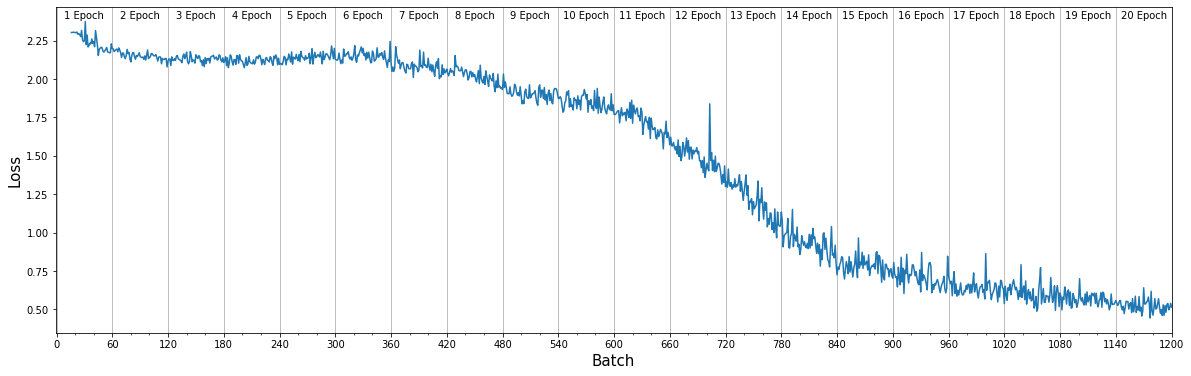

In [14]:
major_xticks = range(0, len(loss_list)+1, 60)
minor_xticks = range(20, len(loss_list)+1, 20)

fig, ax = plt.subplots(figsize=(20, 6))

ax.set_xlim([-1, 1200])

ax.set_xlabel('Batch', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor=True)

ax.plot(range(16, 16+len(loss_list[15:])), loss_list[15:]) # 처음 부터 그리면 초반 5개 정도는 loss 값이 급격하게 낮아지므로 변화량을 제대로 확인하기 어렵다.

ax.grid(axis='x')

for line_idx in range(0, len(loss_list), 60):
    ax.text((line_idx*2 + 60)/2, ax.get_ylim()[1] - ax.get_ylim()[1]/100, 
           s=str(int(line_idx/60)+1) + ' Epoch',
           va='top', ha='center')

plt.show()

## Test

In [25]:
with torch.no_grad():
    model.eval() # with torch.no_grad() 해줬으므로 없어도됨
    num_total_data = 0
    correct = 0
    
    for _, (images, labels) in enumerate(testloader):
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        output_softmax = F.softmax(output, dim=1)
        prediction = torch.argmax(output_softmax, dim=1)
        
        correct += (prediction == labels).sum().item()
        num_total_data += len(labels)
    
    print(f"Accuracy using Dropout: {(correct/num_total_data)*100:.2f}%")

Accuracy using Dropout: 92.70%
